# Graph Theory in Finance:
Some of the basic concepts of Graph Theory can be applied to the technical analysis of equity markets in order to better understand the relationships between individual companies as well as economic sectors. As it stands, my basic understanding of graph theory has become sufficient in order to understand and implement papers on the subject. The paper that will be implmented is the following:

- Attia, J., 2019. **The Applications of Graph Theory to Investing**. arXiv, [online] Available at: <https://arxiv.org/abs/1902.00786> [Accessed 5 January 2021].

This implementation will focus on the graph theory analysis elements of the paper, as opposed to the portfolio construction and performance backtesting elements. These elements will be dealt with in another post as backtesting and implementing these elements within algorithms is outside the scope of this analysis and will be described in detail as I document the construction of my investing infrastructure.

## The Applications of Graph Theory to Investing by Joseph Attia
The first paper to be implemented will be the Joseph Attia paper, which converts correlation matrices generated from a basket of stocks to a graph represented by an adjacency matrix. The vertices of this graph represent individual stocks and the edges represent a weak correlation between their relative price change below a certain threshold.

The longest complete graph that can be found should represent a diversified portfolio. The objective of the paper is better described in its abstract:

"we take a correlation matrix with correlations between the stock prices, and then transform that into a graphable binary adjacency matrix. From this graph, we take a  graph  in  which  each  edge represents weak correlations  between  two  stocks.  Finding the  largest complete  graph  will  produce  a  diversified  portfolio." (Attia, 2019)

The main steps necessary to implement this paper are:

1) From a basket of stocks, create a correlation matrix out of their time-series for a specific period.  
2) Convert this correlation matrix into an adjacency matrix based on a pre-set correlation threshold.
3) Use this adjacency matrix to determine the largest complete complete graph.

Convert this correlation matrix into an adjacency matrix based on a pre-set correlation threshold.
Use this adjacency matrix to determine the largest complete complete graph.

The utility of this algorithm in constructing a portfolio will be examined. Key variables that would affect the utility of this algorithm could be:
- The basket of stocks selected.
- The time-frame of the price time-series of each stock used to calculate the correlation coefficient.
- The threshold used to convert a correlation coefficient to an edge during the coefficient --> adjacency matrix conversion


In [1]:
# Importing necessary packages:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import networkx as nx

## Formatting the Price Time-Series Data and Extracting Correlation Coefficient Matrix:
Before the correlation matrix can be calculated the price time-series for each stock needs to be extracted and formatted in a manner in which we can easily create a matrix. This is done by creating a labeled Pandas Dataframe from a list of ticker symbols that contains only the adjusted closing price for each ticker symbol. The adjusted closing prices are extracted from Yahoo Finance via the yfinance package.

The method `build_prices_df` performs this data extraction and then performs the following data transformation on the adjusted closing price dataframe:

**Adjusted Close Price DataFrame** &rarr; **Price Percent Change Dataframe** &rarr; **Pearson Correlation Coefficient Matrix**

The Correlation Coefficient being calcualted is the Pearson Correlation Coefficient, which is described via the following equation: 

$$𝐶𝑜𝑟𝑟𝑒𝑙𝑎𝑡𝑖𝑜𝑛(X,Y) = \frac{\sum(x - \bar{x})(y-\bar{y})}{\sqrt{\sum(x-\bar{x})^2(y-\bar{y})^2}}$$

All of the data transformations described above can be done via internal pandas methods. 

### The example implementation of this algorithm is done on the example ticker list and correlation coefficient threshold below. The ticker list contains all 30 symbols from the Dow Jones Industrial Average:

In [2]:
ticker_lst = [
    "PG", "MMM", "IBM", "MRK", "AXP", "MCD", "BA", "KO", 
    "CAT", "JPM", "DIS", "JNJ", "WMT", "HD", "INTC", "MSFT",
    "VZ", "CVX", "CSCO", "TRV", "UNH", "GS", "NKE", "V", 
    "AAPL", "WBA", "DOW", "AMGN", "HON", "CRM"
    ]
threshold = 0.30

In [3]:
def build_prices_df(stock_basket_lst, start_date=None, end_date=None):
    """A method that builds a correlation matrix of the adjusted close prices
    for each ticker in the input stock_basket list.
    
    Arguments:
        stock_basket_lst (list): A list containing the ticker strings of each
            stock to be added to the price dataframe.
        
        start_date (str): The start date of the period for which price data
            is queried. If None then all data is queried.

        end_date (str): The end date of the period for which price data
            is queried. If None then all data is queried.
    
    Returns:
        pandas.Dataframe: The dataframe containing the percent change price
            correlation values for each stock in the basket.
            
    """
    # Processing Segmented list into single string for yfinance input:
    stock_basket_str = " ".join(stock_basket_lst)

    # Logic if only a start date is input:
    if start_date is not None:
        full_price_df = yf.download(
            stock_basket_str,
            start=start_date,
            group_by='tickers')
    
    # Brute-Force Creating a new dataframe w/ correct single indexing:
    adj_close_dict = {}
    
    # Iterating over price df building adj_close_dict:
    for ticker in full_price_df:
        
        # ticker is tuple ('TICKER SYMBOL', "column name")
        adj_close_dict[ticker[0]] = full_price_df[ticker[0]][ticker[1]]
        
    # Converting dict into final df:
    prices_df = pd.DataFrame(adj_close_dict, columns=adj_close_dict.keys())
        
    # Performing data transformation of price dataframe:
    corr_matrix = prices_df.pct_change().corr()
        
    return corr_matrix

# Example for testing:
correlation_matrix_eg = build_prices_df(ticker_lst, start_date='2010-01-10')

[*********************100%***********************]  30 of 30 completed


The above example should have produced an 30 x 30 Correlation matrix for each of the tickers described in the above example ticker list. The results of this correlation matrix can be seen below:

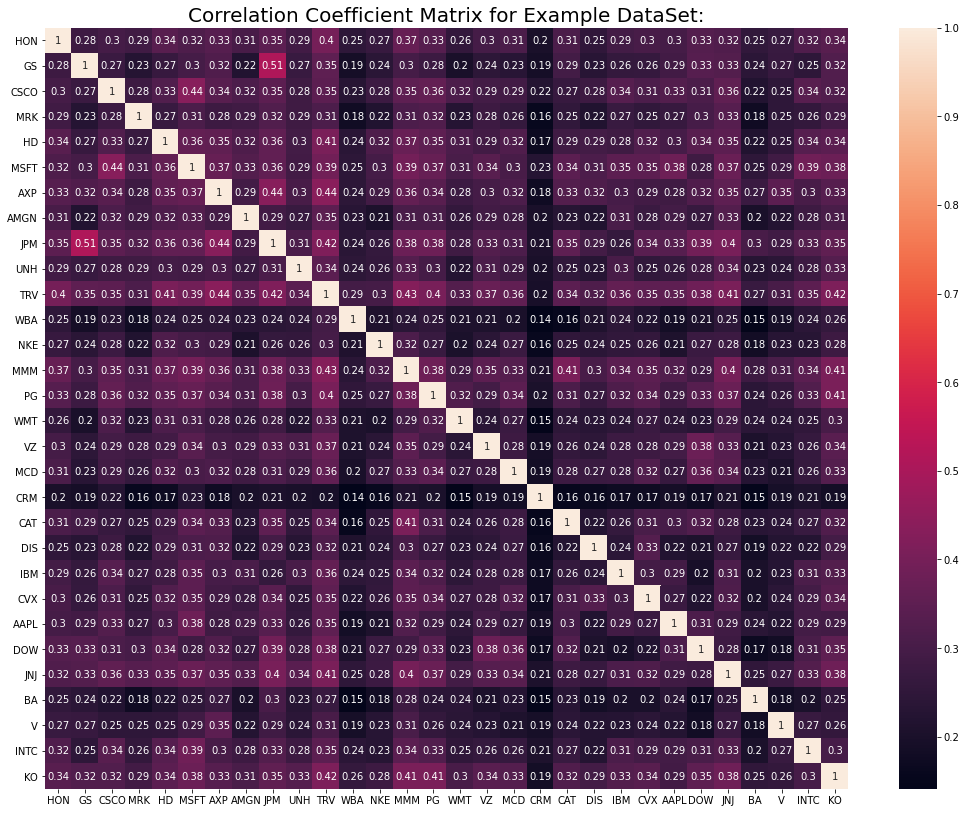

In [4]:
# Plotting and Formatting the Heatmap for Correlations:
plt.figure(figsize=(18,14))
sn.heatmap(correlation_matrix_eg, annot=True)
plt.title("Correlation Coefficient Matrix for Example DataSet:", fontsize=20)
plt.show()

## Converting Correlation Coefficient Matrix to Adjacency Matrix:
The next step is going to be converting the correlation coefficient matrix into an adjacency matrix. This is done by iterating over each element in the matrix and converting the current correlation coefficient to either a 1 or a 0 depending on if the coefficient’s value is greater than a pre-set threshold. The paper uses a threshold of 0.21, which will be the default value for the method that performs the conversion.

**Correlation Coefficient Matrix** &rarr; **Adjacency Matrix**

It should be noted that the threshold used to build the adjacency matrix is somewhat arbitrary and in practical applications this threshold should be different from the 0.21 used in this implementation. 

Another key difference between this theoretical implementation and a potential real world application is the creation of a graph that joins vertices based on strong correlations as opposed to weak correlations (the inverse of this implementation). This could be necessary depending on the portfolio construction use case.

In [5]:
def get_adjacency_matrix(correlation_coeff_matrix, threshold=0.21):
    """A method that converts a correlation matrix into an adjacency matrix.
    
    The method ingests a matrix representing correlation coefficients and
    iterates over each element in the correlation matrix. Elements are 
    converted from a coefficient into a 1 if the coefficient is lower than
    the input threshold and 0 if it is higher.
    
    Arguments:
        correlation_coeff_matrix (pandas.DataFrame): A Pandas dataframe that
            is converted into the adjacency matrix through internal method 
            logic.
        
        threshold (float): The value that determines if an element of the
            correlation matrix is converted into a 0 or a 1.
    
    Returns:
        pandas.DataFrame: The Adjacency Matrix of the correlations between
            the stock baskets closing price percent change.
            
    """
    # Creating the internal method that converts an element to a 0 or a 1 based on value:
    def corr_to_adjacency(value):
        if value > threshold:
            return 0
        else:
            return 1

    # Performing vectorization to the above function and applying it to df elements:
    adj_matrix = correlation_coeff_matrix.apply(np.vectorize(corr_to_adjacency))
    
    return adj_matrix

# Example data:
adj_matrix = get_adjacency_matrix(correlation_matrix_eg, threshold=threshold)
print(adj_matrix.head())

      HON  GS  CSCO  MRK  HD  MSFT  AXP  AMGN  JPM  UNH  ...  DIS  IBM  CVX  \
HON     0   1     1    1   0     0    0     0    0    1  ...    1    1    0   
GS      1   0     1    1   1     1    0     1    0    1  ...    1    1    1   
CSCO    1   1     0    1   0     0    0     0    0    1  ...    1    0    0   
MRK     1   1     1    0   1     0    1     1    0    1  ...    1    1    1   
HD      0   1     0    1   0     0    0     0    0    1  ...    1    1    0   

      AAPL  DOW  JNJ  BA  V  INTC  KO  
HON      1    0    0   1  1     0   0  
GS       1    0    0   1  1     1   0  
CSCO     0    0    0   1  1     0   0  
MRK      1    0    0   1  1     1   1  
HD       0    0    0   1  1     0   0  

[5 rows x 30 columns]


## Performing Subgraph and Cluster Analysis of Graph:
Now that we have a graph via the adjacency matrix we can determine the largest complete subgraph as this will represent a “diversified portfolio”. This is done via a networkx internal method `enumerate_all_cliques` which returns all cliques of a graph. 

In [6]:
# Creating a Graph Object in Networkx:
correlation_graph = nx.Graph(adj_matrix)

# Creating list of all subgraphs with more than 1 vertex:
subgraphs = [graph_lst for graph_lst in nx.enumerate_all_cliques(correlation_graph) if len(graph_lst) > 1]

# Extracting the largest subgraph from the list:
max_graph = subgraphs[-1]
max_graph.sort()
print("Nodes Within the Largest SubGraph:", max_graph)


# Creating a color map that is used to format the network plot based on a vertex's presence in the subraph:
color_map = []
for i in range(0, len(correlation_graph.nodes)):
    
    if list(correlation_graph.nodes)[i] in max_graph:
        color_map.append('#C21807')
    elif list(correlation_graph.nodes)[i] not in max_graph:
        color_map.append('black')
        
print("\nAll Nodes in the Graph:", correlation_graph.nodes)

Nodes Within the Largest SubGraph: ['AAPL', 'AMGN', 'BA', 'CRM', 'DIS', 'GS', 'INTC', 'MCD', 'MRK', 'NKE', 'V', 'VZ', 'WBA', 'WMT']

All Nodes in the Graph: ['HON', 'GS', 'CSCO', 'MRK', 'HD', 'MSFT', 'AXP', 'AMGN', 'JPM', 'UNH', 'TRV', 'WBA', 'NKE', 'MMM', 'PG', 'WMT', 'VZ', 'MCD', 'CRM', 'CAT', 'DIS', 'IBM', 'CVX', 'AAPL', 'DOW', 'JNJ', 'BA', 'V', 'INTC', 'KO']


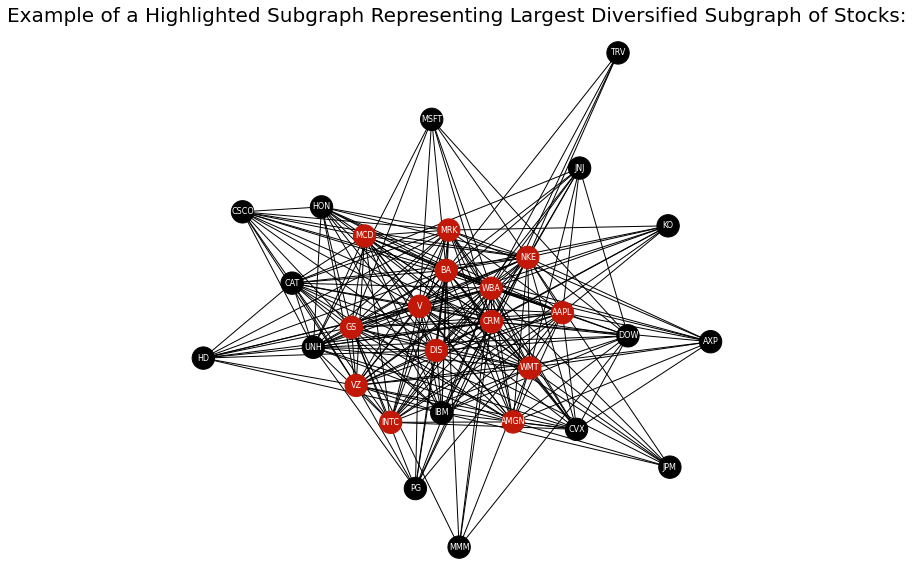

In [7]:
# Formatting and plotting the Example Network Graph: 
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_title(
    'Example of a Highlighted Subgraph Representing Largest Diversified Subgraph of Stocks:',
    fontsize=20)

nx.draw(correlation_graph,
        ax=ax,
        node_color=color_map,
        with_labels=True,
        node_size=500,
        font_size=8,

        font_color="white")

## Conclusion:
From this point the paper goes on to compare the performance of a portfolio constructed by this subgraph to the corresponding index. The results, while not irrelevant, are not particularly significant or relevant. The logic of using correlations to build graphs out of a basket of stocks that highlight both correlated and uncorrelated assets is an important one. 

The logic used in this paper will be implemented into an algorithmic trading strategy and back tested via the `Backtrader` testing engine. Like most technical indicators, graphs generated based on correlation coefficients of price movements have value not as an individual indicator but when integrated as part of a more complex trading algorithm/framework. Backtesting will be done on the utility of these graphs and the results will be published at a future date.

The code displayed in this report will be refactored and re-written in a manner that:

**1) Is more object oriented and class based so it can interface easier with existing data ingestion and loading.**

**2) Supports iteration over various datasets and is able to interface correctly with elements of a backtesting algorithm.**

**3) Allows a machine learning algorithm to continuously adjust the correlation threshold in order to determine the historically optimal level of correlation for a portfolio based on various external input parameters.**

Once this code is re-factored in this manner it should be a useful and critical piece of various quantitative trading algorithms. The results of further analysis and developments of the use of graph theory in financial/technical analysis will be explored and posted.